### About the notebook

GoBig part upscales the model trained in the SegmentationLearner notebook. Make sure the loaded model names match (they should if you left the default ones).
- TODO:
Better refactor code so that each notebook run would be an Upscaling step, instead of all upscaling in a loop. This way would be able to instpect metrics better without sacrificing speed.

### Constants
Pick the depending on the machine you use to train and personal preferences.

- ```batchsize``` sets how big a single train batch was in the small version. It should scale down proportionaly dependong on your res, default = 64 (fits well for 11G graphics card and input pic resolution 64x64)
- ```use_transfer``` sets if we use transfer learning or not. Default is False, because unrealistic scenes in Unity are trained not very good.
For real life applications try to make as realistic of a scene as possible (lighting, shaddows, ambient lights, textures, etc.)
- ```big_res_levels```
Increased resolution transfer sizes, they should always be square.
Input aspect ratio and resolution doesnt matter much, they are squished into square before learning and unsquished afterwards. Should keep that in mind when applying in an actual use case though. Both axes must bigger than maximum defined size in big_res_levels.
Default level training is always (64,64). If big_res_levels is empty [], no transfer learning to increase resolution is done.
- ```model_arch```
How deep your network is. My 11 gig card handles resnet34 well, asuming batchsize = 64 and pic size (64,64). If you have more capable hardware (or use cloud computing), you can try go higher.
- If you have ```len(big_res_levels) > 0```, ```big_epochs``` amount will determine how many epochs will run to make the big picture. Minimum is ```big_epochs > len(big_res_levels) + 1``` because it is a diminishing size for each resolution increment.

In [1]:
batchsize = 80
use_transfer = False
big_res_levels = [128, 256]
from fastai.vision.all import resnet34 as model_arch
big_epochs = 5
save_name = "unity_resnet34"

other choices include: resnet50, resnet101, etc. More info at: https://docs.fast.ai/vision.models.xresnet.html and 
https://fastai1.fast.ai/vision.models.html

# Upscale

#### Helper Funcs

In [2]:
from fastai.learner import patch, delegates, subplots, Recorder
import numpy as np
import math
from matplotlib import pyplot as plt
#Source: https://forums.fast.ai/t/plotting-metrics-after-learning/69937/2
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

### Interpetation

So the whole idea by going bigger is to transfer what our model already learned and train a network with more outputs on top of it. If there are memory problems, try restarting the kernel, then run "constants" cell and then continue form here. If it still does not work, try reducing params, like batchsize, resolutions, etc.

In [3]:
if len(big_res_levels) == 0:
    raise SystemExit("Stop right there! No need to run whole stuff below. Do it selectively!")

In [4]:
from fastai.vision.all import PILImage, get_image_files, DataBlock, unet_learner, ImageBlock, MaskBlock, RandomSplitter, aug_transforms, foreground_acc, DiceMulti,Normalize
from fastai.vision.all import SegmentationInterpretation
import os, pathlib
path = pathlib.Path().absolute()
path = os.path.join(path, "Assets", "Data~")
fnames = get_image_files(os.path.join(path,"screenshots"))
base_img = PILImage.create(fnames[0])

In [5]:
import pandas as pd
codes = pd.read_csv(os.path.join(path,'labels.csv'))

In [6]:
#testing if resolutions fit:
if max(big_res_levels) > min(base_img.shape):
    raise Exception("Sorry, but your input screenshot is higher resolution than your defined 'big_res_levels' maximum value. It must either match or be smaller than screen.")

In [7]:
def label_func(fn): return os.path.join(path,"labels",f"{fn.stem}{fn.suffix}")

In [8]:
lr = slice(3e-5, 2e-3) ## slice(1e-3)
lr

slice(3e-05, 0.002, None)

In [9]:
def train_bigger(epochs, lr, model_name_load, model_name_save, pic_size, is_last):
    current_size = (pic_size,pic_size)
    print("current pic size:",current_size)
    curr_batchsize = batchsize // (pic_size // 64)# - ( pic_size // 64) # a double // makes this int type. Uncomment if bs too big for CUDA
    print("current batchsize:",curr_batchsize)
    print("epochs:",epochs)
    bigger_block = DataBlock(blocks=(ImageBlock, MaskBlock(codes.LabelName)),
                       get_items = get_image_files,
                       get_y = label_func,
                       splitter=RandomSplitter(),
                       batch_tfms=[*aug_transforms(flip_vert = False, max_lighting = 0.1, max_warp=0.05, size=current_size), Normalize])
    dls = bigger_block.dataloaders(os.path.join(path,"screenshots"), path=path, bs=curr_batchsize)
    with unet_learner(dls, model_arch, pretrained = use_transfer, moms=(0.85, 0.75, 0.85), n_out=len(codes["LabelName"])+1, metrics=[foreground_acc, DiceMulti()]) as learn:
        learn.load(model_name_load)
        learn.fit_one_cycle(epochs, lr)
        #!!!! If you use metrics, the models will not properly flush memory, so decrease batch size before that.
        #metrics
        #learn.recorder.plot_metrics()
        #top losses
        #interp = SegmentationInterpretation.from_learner(learn)
        #interp.plot_top_losses(k=5)
        
        learn.save(model_name_save)
        if is_last:
            learn.export("models/"+model_name_save+"_big")
            print("exported final model as:",model_name_save+"_big")

In [10]:
for i in range(len(big_res_levels)):
    prev_name = "64"
    if i > 0:
        prev_name = big_res_levels[i-1]
    
    name_to_load = save_name+"_"+str(prev_name)+"x"
    name_to_save = save_name+"_"+str(big_res_levels[i])+"x"
    
    epochs = big_epochs - i
    print("Training: "+name_to_save)
    train_bigger(1, lr, name_to_load, name_to_save, big_res_levels[i], (i == len(big_res_levels)-1) )

Training: unity_resnet34_128x
current pic size: (128, 128)
current batchsize: 40
epochs: 2


epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.184444,0.091285,0.973289,0.821002,00:25
1,0.133292,0.070329,0.978468,0.855957,00:22


Training: unity_resnet34_256x
current pic size: (256, 256)
current batchsize: 20
epochs: 2


epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.239843,0.118214,0.966556,0.826682,01:16
1,0.147879,0.074915,0.977024,0.882337,01:11


exported final model as: unity_resnet34_256x_big


# Results

#### Helper methods

In [11]:
from fastai.learner import patch, delegates, subplots, Recorder

In [12]:
#Source: https://forums.fast.ai/t/plotting-metrics-after-learning/69937/2
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [23]:
from fastai.learner import load_learner
import os
import numpy as np
from notebook_libs.helper_funcs import show_masked_original_size, path_to_image_bytes, load_image_from_bytes

_test_upload_file = ""
for root, dirs, files in os.walk(
    path, topdown=True, onerror=None, followlinks=False
):
    _test_upload_file = os.path.join(root, files[0])
model_path = os.path.join(path, "models", "unity_resnet34_"+str(big_res_levels[-1])+"x"+"_big")

print(model_path)
print(_test_upload_file)

/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/models/unity_resnet34_256x_big
/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/screenshots/2831.png


In [24]:
learner = load_learner(model_path)
img_bytes = path_to_image_bytes(_test_upload_file)
image = load_image_from_bytes(img_bytes)

#### Predicting Big

torch.Size([256, 256])


<AxesSubplot:>

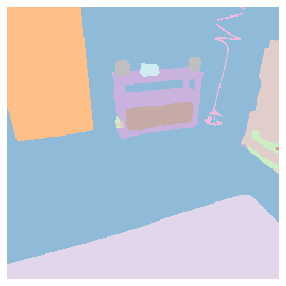

In [26]:
base_img = PILImage.create(fnames[0])
pred = learner.predict(np.array(base_img))[0]
print(pred.shape)
pred.show()

(256, 256)  resizing back to  (480, 640)


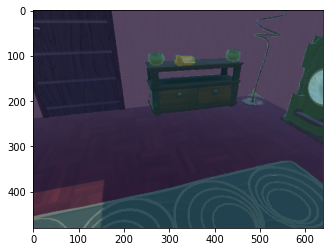

In [27]:
show_masked_original_size(base_img, learner)